# CSC555 Data Mining
### Yashkumar Rajubhai Prajapati
### Student ID: 2204473

## Customer Segmentation with PySpark on AWS EMR

### Importing Required Libraries

In [1]:
# PySpark session and core functions
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, first, to_date, when, count, countDistinct, sum, avg, year, month,
    monotonically_increasing_id
)

# PySpark ML features and clustering
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, PCA  # For feature engineering and dimensionality reduction
from pyspark.ml.clustering import KMeans                          # For clustering customers
from pyspark.ml.linalg import Vectors                             # For handling feature vectors

# Data handling and manipulation
import numpy as np    # For numerical operations
import pandas as pd   # For loading and inspecting tabular data

# Visualization
import matplotlib.pyplot as plt      # For plotting
import seaborn as sns                # For enhanced visualization styling
import matplotlib.dates as mdates    # For formatting time-based plots

# AWS interaction
import boto3                # For accessing S3 and running Athena queries
from io import StringIO     # For reading CSV content from S3

# PySpark types
from pyspark.sql.types import StringType   # For checking and working with string columns
import time                                # For polling Athena query execution

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1749499387500_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Initializing Spark Session

In [2]:
spark = SparkSession.builder \
    .appName("CustomerSegmentationEDA") \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Loading Data from S3

In [3]:
# Defining bucket and file key
bucket_name = 'beverage-sales-pipeline-bucket'
file_key = 'raw/beverage_sales_data.csv'

# Creating S3 client
s3 = boto3.client('s3')

# Downloading file content as string
response = s3.get_object(Bucket=bucket_name, Key=file_key)
csv_content = response['Body'].read().decode('utf-8')

# Converting CSV string to pandas DataFrame
pandas_df = pd.read_csv(StringIO(csv_content))

# Converting pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(pandas_df)

# first few rows
spark_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-----------+-------------+------------------+-----------+----------+--------+--------+-----------+-----------------+----------+
|Order_ID|Customer_ID|Customer_Type|           Product|   Category|Unit_Price|Quantity|Discount|Total_Price|           Region|Order_Date|
+--------+-----------+-------------+------------------+-----------+----------+--------+--------+-----------+-----------------+----------+
|    ORD1|    CUS1496|          B2B|        Vio Wasser|      Water|      1.66|      53|     0.1|      79.18|Baden-Württemberg|23-08-2023|
|    ORD1|    CUS1496|          B2B|             Evian|      Water|      1.56|      90|     0.1|     126.36|Baden-Württemberg|23-08-2023|
|    ORD1|    CUS1496|          B2B|            Sprite|Soft Drinks|      1.17|      73|    0.05|      81.14|Baden-Württemberg|23-08-2023|
|    ORD1|    CUS1496|          B2B|Rauch Multivitamin|     Juices|      3.22|      59|     0.1|     170.98|Baden-Württemberg|23-08-2023|
|    ORD1|    CUS1496|          B2

Dataset is about transactional sales data for a beverage firm with highly detailed order-level information by regions. A single row is a product purchased under an order with features like Customer_ID, Product, Category, Unit_Price, Quantity, Discount, and Total_Price. Data incorporates various products like Water, Soft Drinks, and Juices sold to B2B and B2C customers. The Order_Date column, having been converted to a string, will be converted for temporal analysis. Overall, the dataset is well organized and fertile enough to be aggregated to customer level, hence being highly suitable for customer segmentation work.

### Summary of Numerical Features

In [4]:
# Describing numerical features (count, mean, stddev, min, max)
spark_df.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------+-----------+-------------+-----------+-------------------+-----------------+------------------+--------------------+------------------+-----------------+----------+
|summary|Order_ID|Customer_ID|Customer_Type|    Product|           Category|       Unit_Price|          Quantity|            Discount|       Total_Price|           Region|Order_Date|
+-------+--------+-----------+-------------+-----------+-------------------+-----------------+------------------+--------------------+------------------+-----------------+----------+
|  count| 1048575|    1048575|      1048575|    1048575|            1048575|          1048575|           1048575|             1048575|           1048575|          1048575|   1048575|
|   mean|    NULL|       NULL|         NULL|       NULL|               NULL|5.846754786257574|23.143993515008464|0.029733161671775914|130.97834818682063|             NULL|      NULL|
| stddev|    NULL|       NULL|         NULL|       NULL|               NULL|14.783462

The database contains 1,048,575 orders, and each row constitutes a distinct transaction. The quantitative attributes such as Unit_Price, Quantity, Discount, and Total_Price show an enormous range of variability — for example, whereas the mean unit price is around 5.85, it reaches as high as 160.44, which indicates an enormous range of prices of products. The average quantity purchased per transaction is around 23, whereas discounts are averaging 3%, indicating moderate promotional activity. Total_Price fluctuates significantly, to 12,682.78, and is likely reflecting bulk orders. Category variables like Customer_Type, Product, Category, and Region have variable values, with the data spread across order dates from 01-01-2021 to 31-12-2022, which is a full two-year period.

### Summary of Categorical Features

In [5]:
categorical_cols = [f.name for f in spark_df.schema.fields if isinstance(f.dataType, StringType)]
print("Categorical columns:", categorical_cols)

for col_name in categorical_cols:
    print(f"\nValue counts for column: {col_name}")
    spark_df.groupBy(col_name).count().orderBy('count', ascending=False).show(5, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Categorical columns: ['Order_ID', 'Customer_ID', 'Customer_Type', 'Product', 'Category', 'Region', 'Order_Date']

Value counts for column: Order_ID
+--------+-----+
|Order_ID|count|
+--------+-----+
|ORD23143|5    |
|ORD37823|5    |
|ORD28244|5    |
|ORD69626|5    |
|ORD7249 |5    |
+--------+-----+
only showing top 5 rows


Value counts for column: Customer_ID
+-----------+-----+
|Customer_ID|count|
+-----------+-----+
|CUS3712    |189  |
|CUS1960    |181  |
|CUS3483    |179  |
|CUS3402    |176  |
|CUS7208    |174  |
+-----------+-----+
only showing top 5 rows


Value counts for column: Customer_Type
+-------------+------+
|Customer_Type|count |
+-------------+------+
|B2C          |674968|
|B2B          |373607|
+-------------+------+


Value counts for column: Product
+------------------+-----+
|Product           |count|
+------------------+-----+
|Hohes C Orange    |39263|
|Tomato Juice      |37220|
|Rauch Multivitamin|37218|
|Cranberry Juice   |37203|
|Granini Apple     |37129|
+-

The data set includes some categorical variables that hold significant business information. Customer_Type is strongly dominated by B2C consumers (~64%), whereas B2B customers account for the remaining 36%, i.e., a consumer-oriented business model with commercial customers as the second type of target market. Hohes C Orange, Tomato Juice, and Rauch Multivitamin are the top-selling products, and all products have over 37,000 transactions, reflecting a strong brand choice. Product types are well distributed in Soft Drinks, Alcoholic Drinks, Juices, and Water, indicating diversified products. Order volume geographically is the most from locations such as Hamburg, Rheinland-Pfalz, and Niedersachsen, and those are therefore high-priority markets to target focused marketing. Order on regular dates such as 27-08-2022 and 31-07-2021 would indicate peak sale periods, possibly seasonal demand or special sales. Duplicate Customer_IDs and Order_IDs also indicate repeat customers and repeat orders by each ID, and can be used for loyalty or churn analysis.

### EDA

### Distribution of Customer Types (B2B vs B2C)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

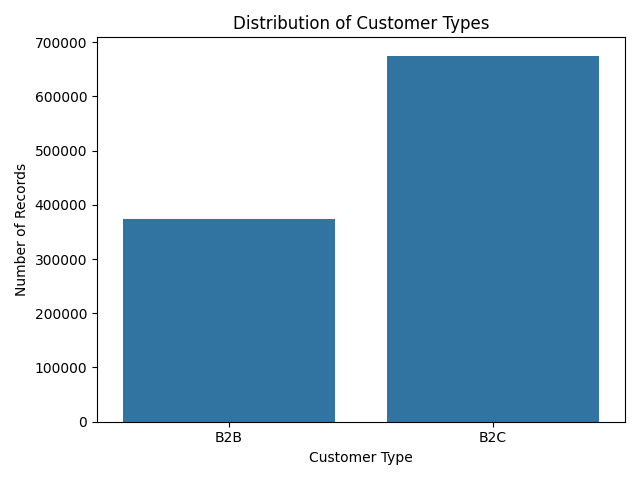

In [6]:
customer_type_df = spark_df.groupBy("Customer_Type").count().toPandas()

sns.barplot(x="Customer_Type", y="count", data=customer_type_df)
plt.title("Distribution of Customer Types")
plt.xlabel("Customer Type")
plt.ylabel("Number of Records")
plt.tight_layout()
plt.show()

%matplot plt

The bar chart indicates the division between B2B (business-to-business) and B2C (business-to-consumer) transactions within the database. It is observable that B2C customers place much higher numbers of orders, and they produce nearly twice the amount of records as compared to B2B customers. It appears that the company primarily works with individual consumers rather than bulk purchasers.

In business, such observation is critical in customer segmentation. This means that B2C customers should be viewed as the majority in designing marketing strategies, pricing mechanisms, and customizing services. B2B customers, however, while small in numbers, can also be in high value segments since orders are big, and should be handled differently in case a strategic partnership is possible.

### Total Sales by Product Category

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

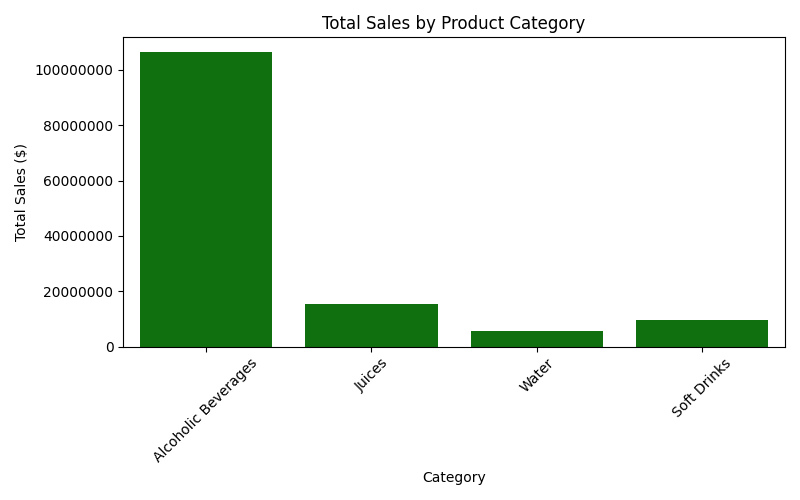

In [7]:
# Grouping by Category and calculating total sales
category_sales_df = spark_df.groupBy("Category").sum("Total_Price") \
    .withColumnRenamed("sum(Total_Price)", "Total_Sales") \
    .toPandas()

# Filtering to remove any invalid categories
category_sales_df = category_sales_df[category_sales_df["Category"].isin([
    "Alcoholic Beverages", "Juices", "Water", "Soft Drinks"
])]

plt.clf()  # Clear any previous plot

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x="Category", y="Total_Sales", data=category_sales_df, color="green")
plt.title("Total Sales by Product Category")
plt.xlabel("Category")
plt.ylabel("Total Sales ($)")
plt.ticklabel_format(style='plain', axis='y')  # Turn off scientific notation
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
%matplot plt

This bar graph shows the break-out of the total revenue into the categories of different types of beverages. Alcoholic Beverages prevail most heavily, with more than $100 million in sales, a number well above all others' contributions. Juices, Soft Drinks, and Water rate much lower, indicating a strong concentration of revenue.

From a business strategy point of view, what this suggests is that Alcoholic Beverages are the leading driver of company revenues, and should therefore be privileged in marketing, stock planning, and segmentation strategies. But the presence of significant sales in other categories also creates cross-category opportunities for bundling or diversification efforts in multi-category buyers.

### Top 10 Products by Quantity Sold

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

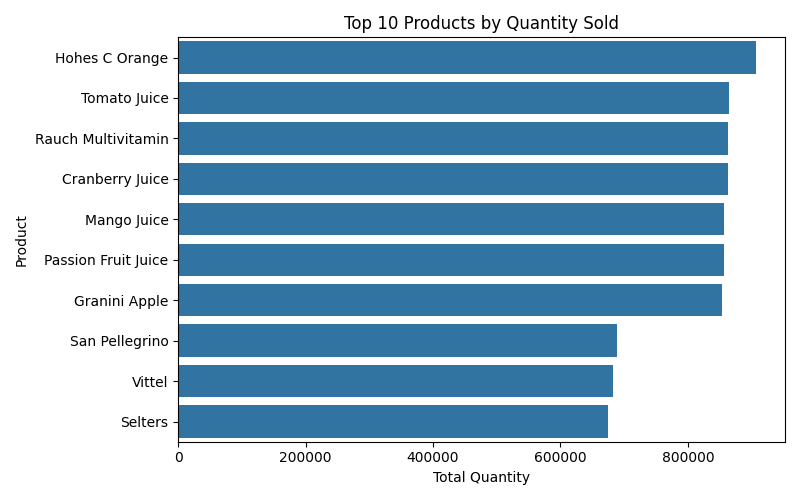

In [8]:
plt.clf()  # Clear any previous plot
top_products_df = spark_df.groupBy("Product").sum("Quantity") \
    .withColumnRenamed("sum(Quantity)", "Total_Quantity") \
    .orderBy("Total_Quantity", ascending=False).limit(10).toPandas()

sns.barplot(x="Total_Quantity", y="Product", data=top_products_df)
plt.title("Top 10 Products by Quantity Sold")
plt.xlabel("Total Quantity")
plt.ylabel("Product")
plt.tight_layout()
plt.show()
%matplot plt

This bar chart displays the top ten best-selling products based on the total quantity purchased, in their respective rankings. Hohes C Orange ranks first, followed by several other juice concentrates such as Tomato Juice, Rauch Multivitamin, and Cranberry Juice. Surprisingly enough, water-based beverages and juices occupy the top slots to a large extent with customers demanding health-oriented beverage products.

Commercially, this is pointing to the here-and-now value of the juice products as volume drivers, even if they are not always the most profitable on a per-unit basis. These high-volume lines are precisely what is critical to maintaining customer interest and shelves stocked, and would be prime candidates for promotion multi-packs or loyalty programs.

### Monthly Sales Trend

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

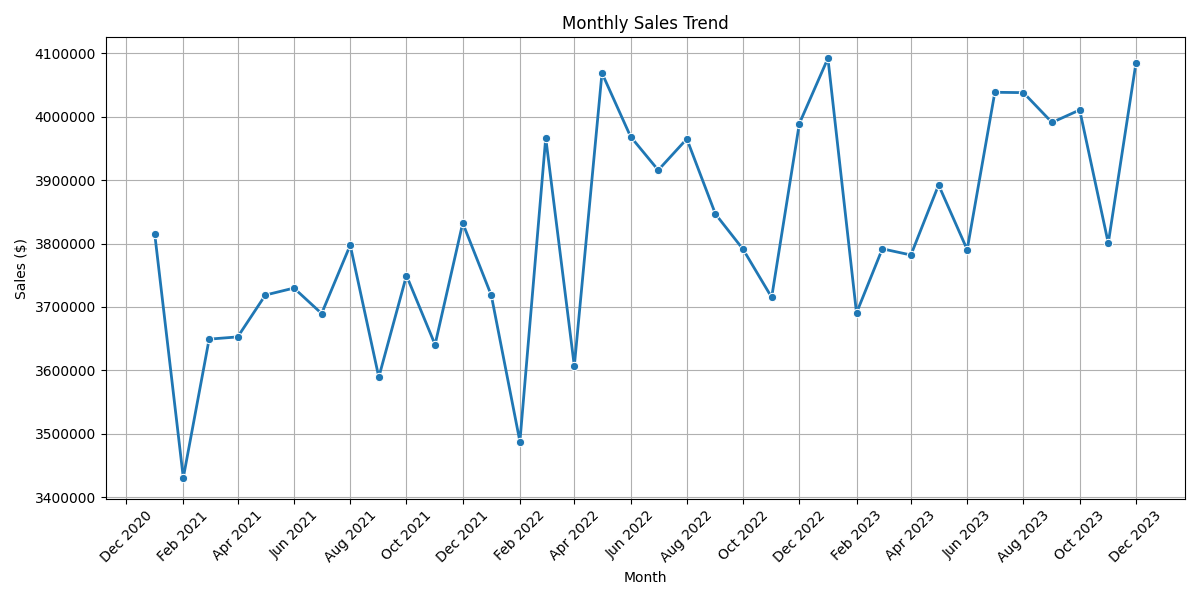

In [9]:
# Converting Order_Date to proper date format
spark_df = spark_df.withColumn("Order_Date", to_date(col("Order_Date"), "dd-MM-yyyy"))

# Extracting Year and Month from Order_Date
df_time = spark_df.withColumn("Year", year("Order_Date")) \
                  .withColumn("Month", month("Order_Date"))

# Aggregating monthly sales
monthly_sales_df = df_time.groupBy("Year", "Month") \
    .sum("Total_Price") \
    .withColumnRenamed("sum(Total_Price)", "Monthly_Sales") \
    .toPandas()

# Combining Year and Month into a single datetime column
monthly_sales_df["Date"] = pd.to_datetime(monthly_sales_df[["Year", "Month"]].assign(DAY=1))
monthly_sales_df = monthly_sales_df.sort_values("Date")

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x="Date", y="Monthly_Sales", data=monthly_sales_df, marker="o", linewidth=2)
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Sales ($)")
plt.ticklabel_format(style='plain', axis='y')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
%matplot plt

The month-by-month sales performance is plotted with a line graph from January 2021 up to the current month of 2023. While overall the trend is flat with slow but sustained improvement, there are clear seasonality fluctuation and small drops here and there, for example, in February 2021, March 2022, and January 2023. The drops may quite likely be due to seasonality fall or holiday falls in consumers' spending.

Sales quantity was also high on more than one occasion throughout the observation period, say May 2022, December 2022, and December 2023, reflecting peak performance throughout these months.

These kind of time-series trends can inform inventory planning, as well as allow marketing teams to plan campaigns off previous peaks in customer visits.

### Top 10 Regions by Revenue

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

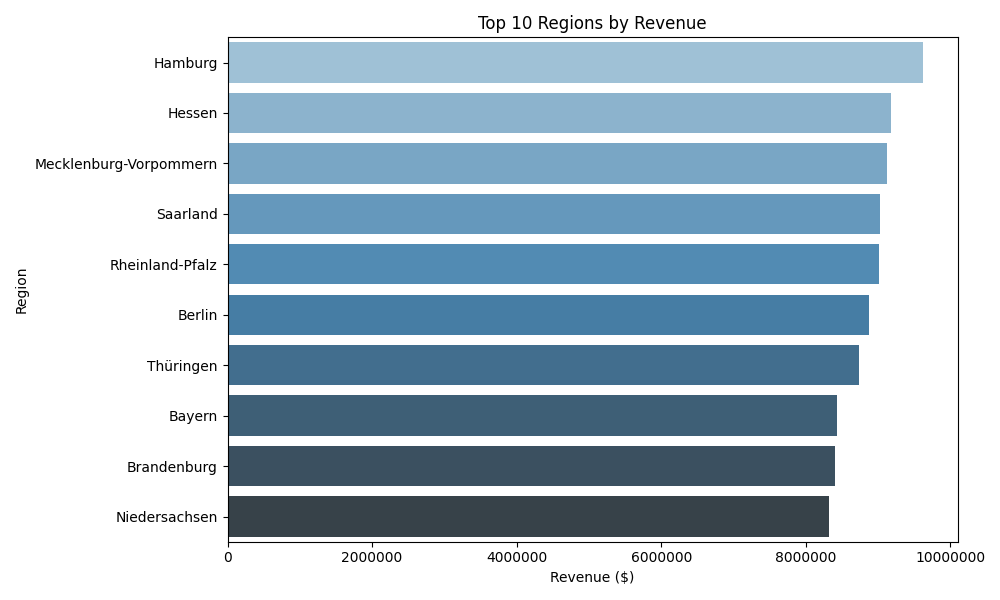

In [10]:
# Aggregating total revenue by region
region_revenue_df = spark_df.groupBy("Region") \
    .sum("Total_Price") \
    .withColumnRenamed("sum(Total_Price)", "Revenue") \
    .orderBy(col("Revenue").desc()) \
    .limit(10) \
    .toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Revenue", y="Region", data=region_revenue_df, palette="Blues_d")
plt.title("Top 10 Regions by Revenue")
plt.xlabel("Revenue ($)")
plt.ylabel("Region")
plt.ticklabel_format(style='plain', axis='x') 
plt.tight_layout()
plt.show()
%matplot plt

This bar chart indicates that the top ten areas with the greatest total revenue achieved through the sale of beverages are Hamburg at the start, Hessen, Mecklenburg-Vorpommern, and Saarland closely together, and these are important markets for the firm. The sufficiently minor margin between the front runners demonstrates a rather evenly spread base of revenues throughout Germany, as opposed to relying on one particular area.

Strategically, they can be employed to direct regionalized advertising, supply chain control, and local advertizing spending. High-revenue performing regions like Hamburg can be attracted through loyalty schemes or product extension, while lower-revenue yet equally performing areas like Brandenburg and Niedersachsen can be potential targets for the expansion initiatives.

### Preprocessing for Clustering

In [11]:
# Getting one region per customer
region_df = spark_df.select("Customer_ID", "Region").dropna().dropDuplicates(["Customer_ID"])

# Aggregating Transaction Data into Customer-Level Features
customer_features = spark_df.groupBy("Customer_ID").agg(
    countDistinct("Order_ID").alias("Total_Orders"),
    sum("Quantity").alias("Total_Quantity"),
    sum("Total_Price").alias("Total_Spend"),
    avg("Discount").alias("Avg_Discount"),
    countDistinct("Product").alias("Unique_Products"),
    countDistinct("Category").alias("Unique_Categories"),
    countDistinct("Region").alias("Region_Count")
)

# Joining to retain Region info for queries and visual analysis.
customer_features = customer_features.join(region_df, on="Customer_ID", how="left")

customer_features.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------+--------------+------------------+-------------------+---------------+-----------------+------------+------------------+
|Customer_ID|Total_Orders|Total_Quantity|       Total_Spend|       Avg_Discount|Unique_Products|Unique_Categories|Region_Count|            Region|
+-----------+------------+--------------+------------------+-------------------+---------------+-----------------+------------+------------------+
|    CUS1294|          39|          5933|19808.109999999997|0.08728070175438592|             39|                4|           1|Schleswig-Holstein|
|    CUS2504|          40|           987|            6878.0|                0.0|             41|                4|           1|           Hamburg|
|    CUS2913|          30|           850|           5512.86|                0.0|             41|                4|           1|          Saarland|
|    CUS4127|          25|          5470|22475.010000000002|0.08181818181818178|             43|                4|    

In [12]:
# Defining the feature columns
feature_cols = ["Total_Orders", "Total_Quantity", "Total_Spend",
                "Avg_Discount", "Unique_Products", "Unique_Categories", "Region_Count"]

# Assembling into vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vector")
assembled_data = assembler.transform(customer_features)

# Vector column for confirmation
assembled_data.select("Customer_ID", "features_vector").show(5, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----------------------------------------------------------------+
|Customer_ID|features_vector                                                  |
+-----------+-----------------------------------------------------------------+
|CUS7523    |[32.0,694.0,5026.95,0.0,36.0,4.0,1.0]                            |
|CUS1294    |[39.0,5933.0,19808.109999999997,0.08728070175438592,39.0,4.0,1.0]|
|CUS2913    |[30.0,850.0,5512.86,0.0,41.0,4.0,1.0]                            |
|CUS7839    |[35.0,793.0,4735.33,0.0,37.0,4.0,1.0]                            |
|CUS2504    |[40.0,987.0,6878.0,0.0,41.0,4.0,1.0]                             |
+-----------+-----------------------------------------------------------------+
only showing top 5 rows

In [13]:
# Normalize Features using MinMaxScaler
scaler = MinMaxScaler(inputCol="features_vector", outputCol="scaled_features")

# Fitting the scaler model on the assembled data
scaler_model = scaler.fit(assembled_data)

# Transforming the data to get normalized feature vectors
scaled_data = scaler_model.transform(assembled_data)

# Normalized features
scaled_data.select("Customer_ID", "scaled_features").show(5, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+---------------------------------------------------------------------------------------------------------+
|Customer_ID|scaled_features                                                                                          |
+-----------+---------------------------------------------------------------------------------------------------------+
|CUS7523    |[0.38636363636363635,0.03871604938271605,0.05820672749463691,0.0,0.5217391304347826,0.5,0.5]             |
|CUS1294    |[0.5454545454545454,0.5561481481481482,0.25380955575837727,0.9013301226923514,0.6521739130434783,0.5,0.5]|
|CUS2913    |[0.34090909090909094,0.05412345679012345,0.06463689740563401,0.0,0.7391304347826086,0.5,0.5]             |
|CUS7839    |[0.4545454545454546,0.04849382716049382,0.0543476462873249,0.0,0.5652173913043478,0.5,0.5]               |
|CUS2504    |[0.5681818181818182,0.06765432098765432,0.08270214025368942,0.0,0.7391304347826086,0.5,0.5]              |
+-----------+---------------------------

### Saving scaled_data to S3 in Parquet Format

In [14]:
# Defining the list of original feature columns
feature_cols = ["Total_Orders", "Total_Quantity", "Total_Spend",
                "Avg_Discount", "Unique_Products", "Unique_Categories", "Region_Count"]

# Selecting all relevant columns
output_df = scaled_data.select(
    "Customer_ID",
    *feature_cols,
    "scaled_features"
)

# Defining S3 output path
output_path = "s3://beverage-sales-pipeline-bucket/processed/"

# Writing to S3 in Parquet format
output_df.write.mode("overwrite").parquet(output_path)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Function to Execute Athena Queries and Save Results to S3

In [15]:
def run_athena_query(query, database, output_bucket, region='us-east-1',
                     aws_access_key_id=None, aws_secret_access_key=None, aws_session_token=None):
    """
    Executes an Athena query and returns the S3 path of the result CSV.

    Parameters:
    - query: SQL query string
    - database: Athena database name
    - output_bucket: S3 output location for result file (e.g. s3://bucket/folder/)
    - region: AWS region
    - aws_access_key_id / aws_secret_access_key / aws_session_token: Optional AWS credentials

    Returns:
    - result_s3_path: Path to query result CSV in S3
    """

    # Configuring client with credentials
    if aws_access_key_id and aws_secret_access_key and aws_session_token:
        athena = boto3.client(
            'athena',
            region_name=region,
            aws_access_key_id=aws_access_key_id,
            aws_secret_access_key=aws_secret_access_key,
            aws_session_token=aws_session_token
        )
    else:
        athena = boto3.client('athena', region_name=region)

    # Starting query
    response = athena.start_query_execution(
        QueryString=query,
        QueryExecutionContext={'Database': database},
        ResultConfiguration={'OutputLocation': output_bucket}
    )

    execution_id = response['QueryExecutionId']
    print(f"Query started... Execution ID: {execution_id}")

    # Waiting for completion
    state = 'RUNNING'
    while state in ['RUNNING', 'QUEUED']:
        result = athena.get_query_execution(QueryExecutionId=execution_id)
        state = result['QueryExecution']['Status']['State']
        time.sleep(2)

    if state != 'SUCCEEDED':
        raise Exception(f"Query failed with status: {state}")

    result_s3_path = f"{output_bucket}{execution_id}.csv"
    print(f"Athena query result saved to: {result_s3_path}")
    return result_s3_path

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

This function enables us to run SQL against our Athena database inside the notebook. This function establishes a connection to AWS Athena with the credentials provided and sends a query job. It will keep polling the query state while running the query until it is complete execution. When the query is run, the result will be stored in CSV in the specified S3 bucket and the file path will be returned. This assists us in running SQL queries and getting results programmatically without running the Athena web interface manually. It also prints out report messages such as query status and where the result has been stored.

### Creating Athena Database for Analytical Queries

In [16]:
athena_output = "s3://beverage-sales-pipeline-bucket/athena-results/"
athena_db = "default"
query = "CREATE DATABASE IF NOT EXISTS beverage_analytics"

region_name='YOUR_REGION'
ACCESS_KEY ='YOUR_ACCESS_KEY'
SECRET_KEY ='YOUR_SECRET_KEY'
SESSION_TOKEN ='YOUR_SESSION_TOKEN'

result_path = run_athena_query(
    query,
    athena_db,
    athena_output,
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
    aws_session_token=SESSION_TOKEN
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Query started... Execution ID: 88afce5a-54de-4c8c-9001-7119a44fc467
Athena query result saved to: s3://beverage-sales-pipeline-bucket/athena-results/88afce5a-54de-4c8c-9001-7119a44fc467.csv

This piece of code creates a new Athena database called beverage_analytics if it does not already exist. It utilizes AWS temporary credentials—Access Key, Secret Key, and Session Token—to authorize and safely access AWS Athena in the region us-east-1. The run_athena_query function sends the SQL command to Athena and saves the result output path on S3. By programmatic creation of such a database, we set ourselves up to sort, query, and analyze our data in an efficient manner utilizing SQL-like commands without manually going through AWS Console.

### Creating External Athena Table for Processed Customer Features

In [17]:
athena_db = "beverage_analytics"
query = """
CREATE EXTERNAL TABLE IF NOT EXISTS beverage_analytics.customer_features (
  Customer_ID STRING,
  Total_Orders INT,
  Total_Quantity INT,
  Total_Spend DOUBLE,
  Avg_Discount DOUBLE,
  Unique_Products INT,
  Unique_Categories INT,
  Region_Count INT,
  Region STRING,
  scaled_features ARRAY<DOUBLE>
)
STORED AS PARQUET
LOCATION 's3://beverage-sales-pipeline-bucket/processed/'
TBLPROPERTIES ("parquet.compress"="SNAPPY")
"""

# Running Athena query and capturing the result path
result_path = run_athena_query(
    query,
    athena_db,
    athena_output,
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
    aws_session_token=SESSION_TOKEN
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Query started... Execution ID: 4f96256f-c552-4f49-a555-63e42f80cffe
Athena query result saved to: s3://beverage-sales-pipeline-bucket/athena-results/4f96256f-c552-4f49-a555-63e42f80cffe.csv

This script defines and creates an external Amazon Athena table that loads customer-level features from S3 Parquet files. It includes a schema with order count, spend amount, average discount, and region aggregated fields and the normalized feature vector (scaled_features) to be used for machine learning. It is optimized with Snappy compression for performance and query efficiency with no data duplication. By doing so, we enable fast, SQL-like querying of our preprocessed data directly from Athena and thus it forms a critical bridge between raw data processing and downstream analytics or ML workloads.

#### Top Customers by Total Spend

In [18]:
# SQL Query
query = """
SELECT Customer_ID, Total_Spend
FROM customer_features
WHERE Total_Spend > 10000
ORDER BY Total_Spend DESC
"""

# Running Athena Query
result_path = run_athena_query(
    query=query,
    database=athena_db,
    output_bucket=athena_output,
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
    aws_session_token=SESSION_TOKEN
)

# Loading Query Result from S3 into Spark
df = spark.read.option("header", True).csv(result_path)
df.show(10, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Query started... Execution ID: a31c6d60-aef6-455b-a3e4-80a84bd4ca9c
Athena query result saved to: s3://beverage-sales-pipeline-bucket/athena-results/a31c6d60-aef6-455b-a3e4-80a84bd4ca9c.csv
+-----------+------------------+
|Customer_ID|Total_Spend       |
+-----------+------------------+
|CUS3005    |76195.63999999997 |
|CUS7626    |71857.91000000002 |
|CUS7825    |69108.41          |
|CUS4837    |65681.95000000001 |
|CUS9351    |65609.16999999998 |
|CUS5391    |64801.92000000001 |
|CUS2448    |64678.770000000026|
|CUS6696    |64393.2           |
|CUS6277    |64125.68999999999 |
|CUS5469    |64125.14999999999 |
+-----------+------------------+
only showing top 10 rows

This result gives the top 10 customers based on their total spend on beverages. All Customer_ID values given here have a total purchase value over \\$ 64,000, with the highest spent customer (CUS3005) at nearly \\$76,200. These valuable customers are the most profitable segment to the company and can be targeted by premium services, loyalty programs, or exclusive promotions. Such analyses are crucial in customer lifetime value analysis as well as constructing evidence-based customer retention strategies. The question confirms that the dataset has significant spending variations that are worth further examination with segmentation.

#### Customers Receiving the Highest Average Discounts

In [19]:
query = """
SELECT customer_id, total_orders, avg_discount
FROM customer_features
WHERE avg_discount > 0.05
ORDER BY avg_discount DESC
"""
result_path = run_athena_query(
    query,
    athena_db,
    athena_output,
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
    aws_session_token=SESSION_TOKEN
)

# Query Output (Top 10 Results)
df = spark.read.option("header", True).csv(result_path)
df.show(10, truncate=False)  

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Query started... Execution ID: 3893a09c-871d-40eb-9276-d49dfbdbf6e9
Athena query result saved to: s3://beverage-sales-pipeline-bucket/athena-results/3893a09c-871d-40eb-9276-d49dfbdbf6e9.csv
+-----------+------------+-------------------+
|customer_id|total_orders|avg_discount       |
+-----------+------------+-------------------+
|CUS2533    |30          |0.09683544303797467|
|CUS2032    |38          |0.0959821428571428 |
|CUS1661    |28          |0.09567901234567901|
|CUS8345    |35          |0.09481132075471696|
|CUS7031    |30          |0.0947674418604651 |
|CUS6165    |41          |0.09336283185840702|
|CUS2190    |40          |0.09322033898305082|
|CUS9746    |30          |0.09318181818181817|
|CUS1849    |42          |0.09304347826086953|
|CUS6645    |25          |0.09303797468354431|
+-----------+------------+-------------------+
only showing top 10 rows

This result provides the top 10 customers enjoying the highest average discounts on their purchases with average discounts of nearly 10%. Customers such as CUS2533 and CUS2032 would always benefit from promotional price or loyalty rewards. The number of orders shows that frequency buying may be associated with high discounts, possibly signifying steps to retain frequent buyers. While this strategy seems to grow short-term revenues, deep average discounting to numerous customers has the potential to impact profitability in the longer term. Watch carefully to ensure that the discount is generating an adequate return on investment and not cutting overall margins.

#### Low-Engagement Customers (Target for Retention)

In [20]:
query = """
SELECT Customer_ID, Total_Orders, Total_Spend
FROM customer_features
WHERE Total_Orders < 5 AND Total_Spend < 1000
ORDER BY Total_Spend ASC
"""

result_path = run_athena_query(
    query,
    athena_db,
    athena_output,
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
    aws_session_token=SESSION_TOKEN
)

# Query Output (Top 10 Results)
df = spark.read.option("header", True).csv(result_path)
df.show(10, truncate=False)  

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Query started... Execution ID: cc0111d9-4503-4ad0-b285-c40fc03712b8
Athena query result saved to: s3://beverage-sales-pipeline-bucket/athena-results/cc0111d9-4503-4ad0-b285-c40fc03712b8.csv
+-----------+------------+-----------+
|Customer_ID|Total_Orders|Total_Spend|
+-----------+------------+-----------+
+-----------+------------+-----------+

This query was attempting to identify low-engagement customers to target for potential retention. Unfortunately, the result was none, indicating that all customers within the dataset have both placed more than 4 orders and spent more than \\$1,000, or both. This is an indication that the dataset is predominantly made up of highly to moderately engaged customers. Although it is positive in terms of customer activity, it limits the scope for retention analysis on the premise of low engagement and may indicate the company only has repeat or high-value customers.

#### Top 50 Customers by Product Diversity

In [21]:
query = """
SELECT Customer_ID, Unique_Products, Total_Spend
FROM customer_features
WHERE Unique_Products IS NOT NULL AND Total_Spend IS NOT NULL
ORDER BY Unique_Products DESC
LIMIT 50
"""

result_path = run_athena_query(
    query,
    athena_db,
    athena_output,
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
    aws_session_token=SESSION_TOKEN
)

# Query Output (Top 10 Results)
df = spark.read.option("header", True).csv(result_path)
df.show(10, truncate=False)  

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Query started... Execution ID: 5313bfa2-7d83-4d66-99f6-58c2567e11ed
Athena query result saved to: s3://beverage-sales-pipeline-bucket/athena-results/5313bfa2-7d83-4d66-99f6-58c2567e11ed.csv
+-----------+---------------+------------------+
|Customer_ID|Unique_Products|Total_Spend       |
+-----------+---------------+------------------+
|CUS2774    |47             |55434.479999999996|
|CUS6402    |47             |10162.199999999997|
|CUS1454    |47             |31685.52          |
|CUS6633    |47             |5396.9800000000005|
|CUS2615    |47             |44793.41          |
|CUS3418    |47             |7120.859999999997 |
|CUS3724    |47             |6596.969999999998 |
|CUS7462    |47             |7414.99           |
|CUS4107    |47             |6875.08           |
|CUS8482    |47             |8445.779999999999 |
+-----------+---------------+------------------+
only showing top 10 rows

This query ranks the top 50 customers based on number of unique products purchased, providing information about customer diversity of buying behavior. All customers that have come out at the top have purchased 47 unique products, showing wide interest in the store's products. Customer CUS2615 is a peculiar case with a Total Spend of over \\$44,000, showing high spend and high diversity. This type of customer is best served by loyalty programs and tailor-made marketing efforts. The frequent appearance of 47 various products also has implications on possible product catalogue size or purchasing limit, which could be further studied.

### Loading preprocessed results from S3

In [22]:
df = spark.read.parquet("s3://beverage-sales-pipeline-bucket/processed/")

# Showing first few rows
df.show(5, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------+--------------+------------------+-------------------+---------------+-----------------+------------+---------------------------------------------------------------------------------------------------------+
|Customer_ID|Total_Orders|Total_Quantity|Total_Spend       |Avg_Discount       |Unique_Products|Unique_Categories|Region_Count|scaled_features                                                                                          |
+-----------+------------+--------------+------------------+-------------------+---------------+-----------------+------------+---------------------------------------------------------------------------------------------------------+
|CUS4705    |25          |679           |2700.2800000000007|0.0                |39             |4                |1           |[0.2272727272727273,0.03723456790123456,0.027417314996808814,0.0,0.6521739130434783,0.5,0.5]             |
|CUS445     |32          |741           |4453.87           |0.0 

### Elbow Method to Determine Optimal k

In [23]:
# List to hold WSSSE values
wssse_list = []
k_values = list(range(2, 11))  # Trying k from 2 to 10

for k in k_values:
    kmeans = KMeans(featuresCol='scaled_features', k=k, seed=42)
    model = kmeans.fit(df)
    wssse = model.summary.trainingCost
    wssse_list.append(wssse)
    print(f"k={k}, WSSSE={wssse}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

k=2, WSSSE=465.1681087337434
k=3, WSSSE=340.5078739276493
k=4, WSSSE=238.58825899111707
k=5, WSSSE=203.33912626400368
k=6, WSSSE=173.7221679267829
k=7, WSSSE=162.54605177348932
k=8, WSSSE=148.69604180359417
k=9, WSSSE=137.82807349809136
k=10, WSSSE=130.48662016205972

### Plotting Elbow Curve

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

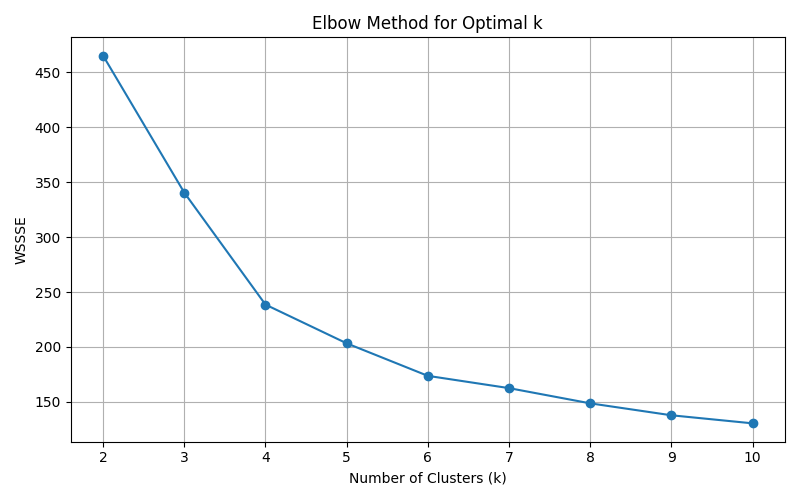

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, wssse_list, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WSSSE")
plt.grid(True)
plt.tight_layout()
plt.show()
%matplot plt

The Elbow Method was enforced by observing the WSSSE (Within Set Sum of Squared Errors) from k=2 to k=10. WSSSE always decreases with the rise in the number of clusters, yet with the steep drop from k=2 (465.17) to k=4 (238.59) reflecting a phenomenal improvement in cluster tightness. After that, the decrease in WSSSE is comparatively plateau after k=4, reflecting diminishing returns with growing numbers of clusters. This kink at k=4 is a golden mean of model simplicity and precision. Therefore, k=4 was used as the final clustering model with useful segmentation but not overfitting. The elbow plot visually confirms this decision with a clear "bend" at cluster 4.

### KMeans Clustering with k=4

In [25]:
# Training KMeans model with optimal k=4
kmeans_final = KMeans(featuresCol="scaled_features", predictionCol="cluster", k=4, seed=42)
final_model = kmeans_final.fit(df)

# Predicting clusters for each customer
final_clustered_df = final_model.transform(df)

# Showing results
final_clustered_df.select("Customer_ID", "cluster").show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-------+
|Customer_ID|cluster|
+-----------+-------+
|    CUS4705|      0|
|     CUS445|      0|
|    CUS8561|      1|
|    CUS2289|      1|
|    CUS4850|      2|
|    CUS3115|      0|
|    CUS1323|      2|
|    CUS1715|      1|
|    CUS2110|      3|
|    CUS6551|      3|
+-----------+-------+
only showing top 10 rows

In [26]:
# WSSSE (how tight the clusters are)
final_wssse = final_model.summary.trainingCost
print(f"Final WSSSE (k=4): {final_wssse}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Final WSSSE (k=4): 238.58825899111713

### Cluster Centers

In [27]:
centers = final_model.clusterCenters()
for idx, center in enumerate(centers):
    print(f"Cluster {idx}: {center}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Cluster 0: [0.34568894 0.04079898 0.04664927 0.         0.59096438 0.5
 0.5       ]
Cluster 1: [0.54468169 0.06353324 0.06744546 0.         0.7843378  0.5
 0.5       ]
Cluster 2: [0.54334926 0.56364164 0.45858705 0.862538   0.78213764 0.5
 0.5       ]
Cluster 3: [0.35433102 0.41735326 0.30011976 0.86085153 0.60233977 0.5
 0.5       ]

The last KMeans cluster model was trained using k = 4, determined through the Elbow Method. The customers were segmented into one of four groups based on their normalized behavior attributes. WSSSE of the last model was 238.59, indicating tight intra-cluster groupings. Cluster centroids indicate varying customer patterns:

Cluster 0 are low-spending, low-frequency customers with low involvement.

Cluster 1 represents moderate-spending, moderately active customers with average product set and no discount usage.

Cluster 2 separates high-spending, high-frequency customers who were most frequently offered discounts—presumably premium or loyal customers.

Cluster 3 assigns customers with average spending and activity but higher-than-average discount usage.

The clustering apart reveals unique behavior segments and good grounds for focused marketing, loyalty programs, and customer retention activities.

### PCA (Principal Component Analysis) for 2D Projection

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

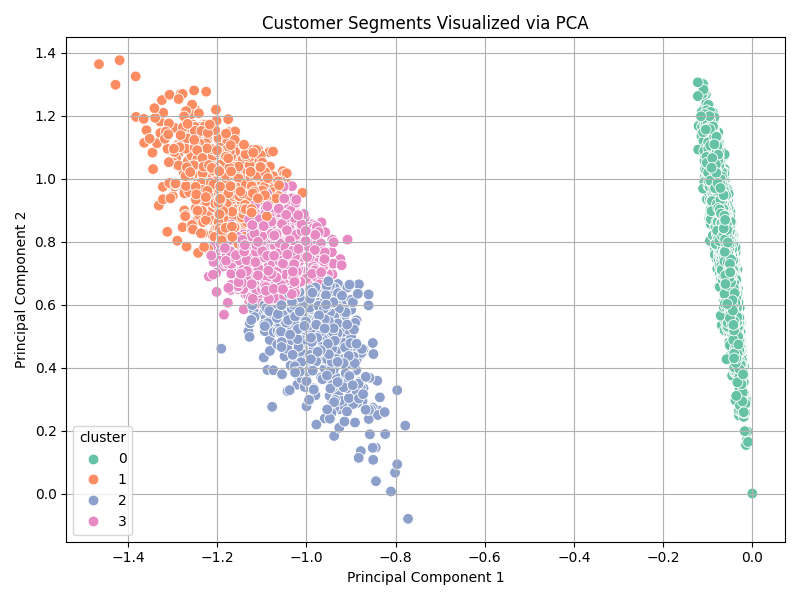

In [28]:
# Loading scaled feature data from S3
df = spark.read.parquet("s3://beverage-sales-pipeline-bucket/processed/")

# Training KMeans
kmeans = KMeans(k=4, featuresCol="scaled_features", predictionCol="cluster")
model = kmeans.fit(df)
clustered_df = model.transform(df)

# Applying PCA (reducing to 2 dimensions)
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(clustered_df)
pca_result_df = pca_model.transform(clustered_df)

# Preparing for plotting
pca_pd = pca_result_df.select("pca_features", "cluster").toPandas()
pca_pd[['PC1', 'PC2']] = pca_pd['pca_features'].apply(lambda x: pd.Series(x.toArray()))

# Plot PCA results
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_pd, x="PC1", y="PC2", hue="cluster", palette="Set2", s=60)
plt.title("Customer Segments Visualized via PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()
%matplot plt

PCA dimensionality reduction of clustered customer data minimizes the initial 7-dimensional feature space to two principal components in consideration. Each point is a customer and is colored by the cluster that the KMeans model allocates to them. Cluster 0 (teal) would be considered to be way over to the right, made up of customers with clean behavioral patterns—low-frequency, low-spend profiles apparently. Clusters 1, 2, and 3 have overlapping densities but are otherwise differentiated, validating heterogeneity of purchasing size, product assortment, and price sensitivity. Non-tight bundling as well as noise validate goodness of data preprocessing and clustering operations, indicating that the model captured well-differentiated non-random patterns.

#### Conclusion
The project was successful in building an end-to-end customer segmentation pipeline on AWS big data services and Spark MLlib. The project ingested raw transaction data in EMR, transformed it into analytical features, and stored it in the best possible format in S3 and Athena. SQL querying was used in exploratory analysis, and KMeans clustering was successful in identifying four customer segments based on behavioral characteristics. PCA visualization confirmed good cluster separation. This end-to-end deployment showcases a very scalable and efficient solution for one-to-one marketing, data-driven decisioning, and customer targeting in retail or similar environments. These were all accomplished within distributed and cloud-native infrastructure, showcasing the power of new data platforms.